### Recreating Figure 2C from Bloniasz, Oyama, and Stephen (2024)

Using **your** `Model` class and `FilteredPointProcess` (which differ from the old `PointProcessModel` and `FPP` classes).

In [14]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd
import nitime.algorithms as tsa
import nitime.utils as tsu
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks

# Import the classes from your actual package code:
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess

# Helper function to convert spike times to a binary train
def create_spike_train(spike_times, time_axis, fs):
    """Converts spike times (in seconds) to a 0/1 spike train vector."""
    spike_train = np.zeros_like(time_axis)
    indices = (np.array(spike_times) * fs).astype(int)
    indices = indices[indices < len(time_axis)]
    spike_train[indices] = 1
    return spike_train

#### 1) Create and simulate a univariate point process via `Model`

We specify `model_name="gaussian"` so that `_create_cif()` will build a `GaussianCIF` under the hood, based on the code from:

```python
self.cif = GaussianCIF(**self.model_params, **sim_params)
```

Then `_simulate_process()` will attach a `PointProcess` and generate spikes.

In [15]:


model_name = "gaussian"

# For the GaussianCIF, we assume you pass in peak_height, center_frequency, etc.:
model_params = {
    "peak_height": [5000],
    "center_frequency": [1],
    "peak_width": [0.1],
    "lambda_0": [500]
}

simulation_params = {
    "fs": 1000,       # sampling frequency
    "T": 60,          # total sim time (sec)
    "simulate": True, # automatically simulate
    "seed": 20        # reproducible
}

model = Model(
    model_name=model_name,
    model_params=model_params,
    simulation_params=simulation_params
)

cif_time_domain = model.cif.time_domain.intensity_realization  # if available

cif_copy = np.real(np.abs(cif_time_domain))

# The time axis is from your property 'model.time_axis'
time_axis = model.time_axis

# The spike times from the simulation are in 'model.spikes'
spikes = model.spikes
spike_train = create_spike_train(spike_times=spikes, time_axis=time_axis, fs=simulation_params["fs"])

print(f"Number of spikes: {spike_train.sum()}")

Number of spikes: 23514.0


/var/folders/y_/cv0__l8d15s4svd34bshwfm40000gn/T/ipykernel_53314/3620648312.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = (np.array(spike_times) * fs).astype(int)


#### 2) Create a `FilteredPointProcess` and apply filters

Your posted code shows that we do:
```python
fpp = FilteredPointProcess(model=model, filters={...})
fpp.apply_filter_sequences([['GABA'], ['GABA', '1/f']])
```
rather than `perform_convolutions()`. This method sets up the final arrays:
`fpp.final_time_series_per_process` (shape = #sequences x #timepoints),
`fpp.final_spectrum_per_process`, etc.

We can then pick off the single-filter or two-filter signals from these arrays.

In [16]:
filters_dict = {"filter_1": "GABA", "filter_2": "1/f"}

fpp = FilteredPointProcess(
    model=model,
    filters=filters_dict,
    filter_params=None  # or a dict if needed
)

fpp_1 = FilteredPointProcess(
    model=model,
    filters=filters_dict,
    filter_params=None  # or a dict if needed
)

fpp_2 = FilteredPointProcess(
    model=model,
    filters=filters_dict,
    filter_params=None  # or a dict if needed
)


# Apply both filter sequences:
#   1) GABA alone
#   2) GABA then 1/f
fpp_1.apply_filter_sequences([
    ["filter_1"]
])
fpp_2.apply_filter_sequences([
    ["filter_1", "filter_2"]
])


# The results are stored in final_time_series_per_process:
#   fpp.final_time_series_per_process[0] = output after GABA only
#   fpp.final_time_series_per_process[1] = output after GABA + 1/f

sim_PSPs_GABA = fpp_1.final_time_series_per_process[0]
sim_PSPs_GABA_1f = fpp_2.final_time_series_per_process[0]

print(f"PSPs with GABA only shape: {sim_PSPs_GABA.shape}")
print(f"PSPs with GABA + 1/f shape: {sim_PSPs_GABA_1f.shape}")

Applied filter sequences (with types): [[('filter_1', 'GABA')]]
Applied filter sequences (with types): [[('filter_1', 'GABA'), ('filter_2', '1/f')]]
PSPs with GABA only shape: (60000,)
PSPs with GABA + 1/f shape: (60000,)


#### 3) Retrieve the frequency-domain info from the `Model` and from the `FilteredPointProcess`

* `model.frequencies` → The frequency axis
* `model.cif.PSD` → The CIF's power spectrum
* If you want “Spectrum of CIF + Mean Rate” as in your original code, you add `lambda_0`.
* The final filtered spectra are in `fpp.final_spectrum_per_process[0]` (GABA) and `[1]` (GABA+1/f).

In [17]:
# The frequency axis used in your univariate CIF
frequencies = model.frequencies

# The raw CIF PSD (univariate)
cif_PSD = model.cif.PSD  # per your FilteredPointProcess code, univariate is .PSD

# If you want the "Spectrum of CIF + Mean Rate" as a simple addition:
# We'll assume lambda_0 is stored as [500], so use that:
lambda_0_val = model_params["lambda_0"][0]
pp_PSD = cif_PSD + lambda_0_val  # your original approach

# Meanwhile, the final spectra after GABA or GABA+1/f are here:
h_spectrum = fpp_1.final_spectrum_per_process[0]   # after single filter ("GABA")
final_spectrum = fpp_2.final_spectrum_per_process[0]  # after two filters ("GABA"+"1/f")


#### 4) Exactly replicate your multi-subplot figure logic

We'll take the same code you provided for styling, alpha scaling for spikes, log-log PSD, etc. The **only** differences are:
- We now draw `sim_PSPs_GABA` from `fpp.final_time_series_per_process[0]`, etc.
- The CIF we plot is `cif_copy = np.abs(model.cif.time_domain.intensity_realization)`, and the spike train from `spike_train`.
- The PSD references come from `model.cif.PSD` or from `fpp.final_spectrum_per_process[..]`.

Everything else (subplots, text, alpha for spikes) is the same. Note that you can remove or rename any code that references old classes.

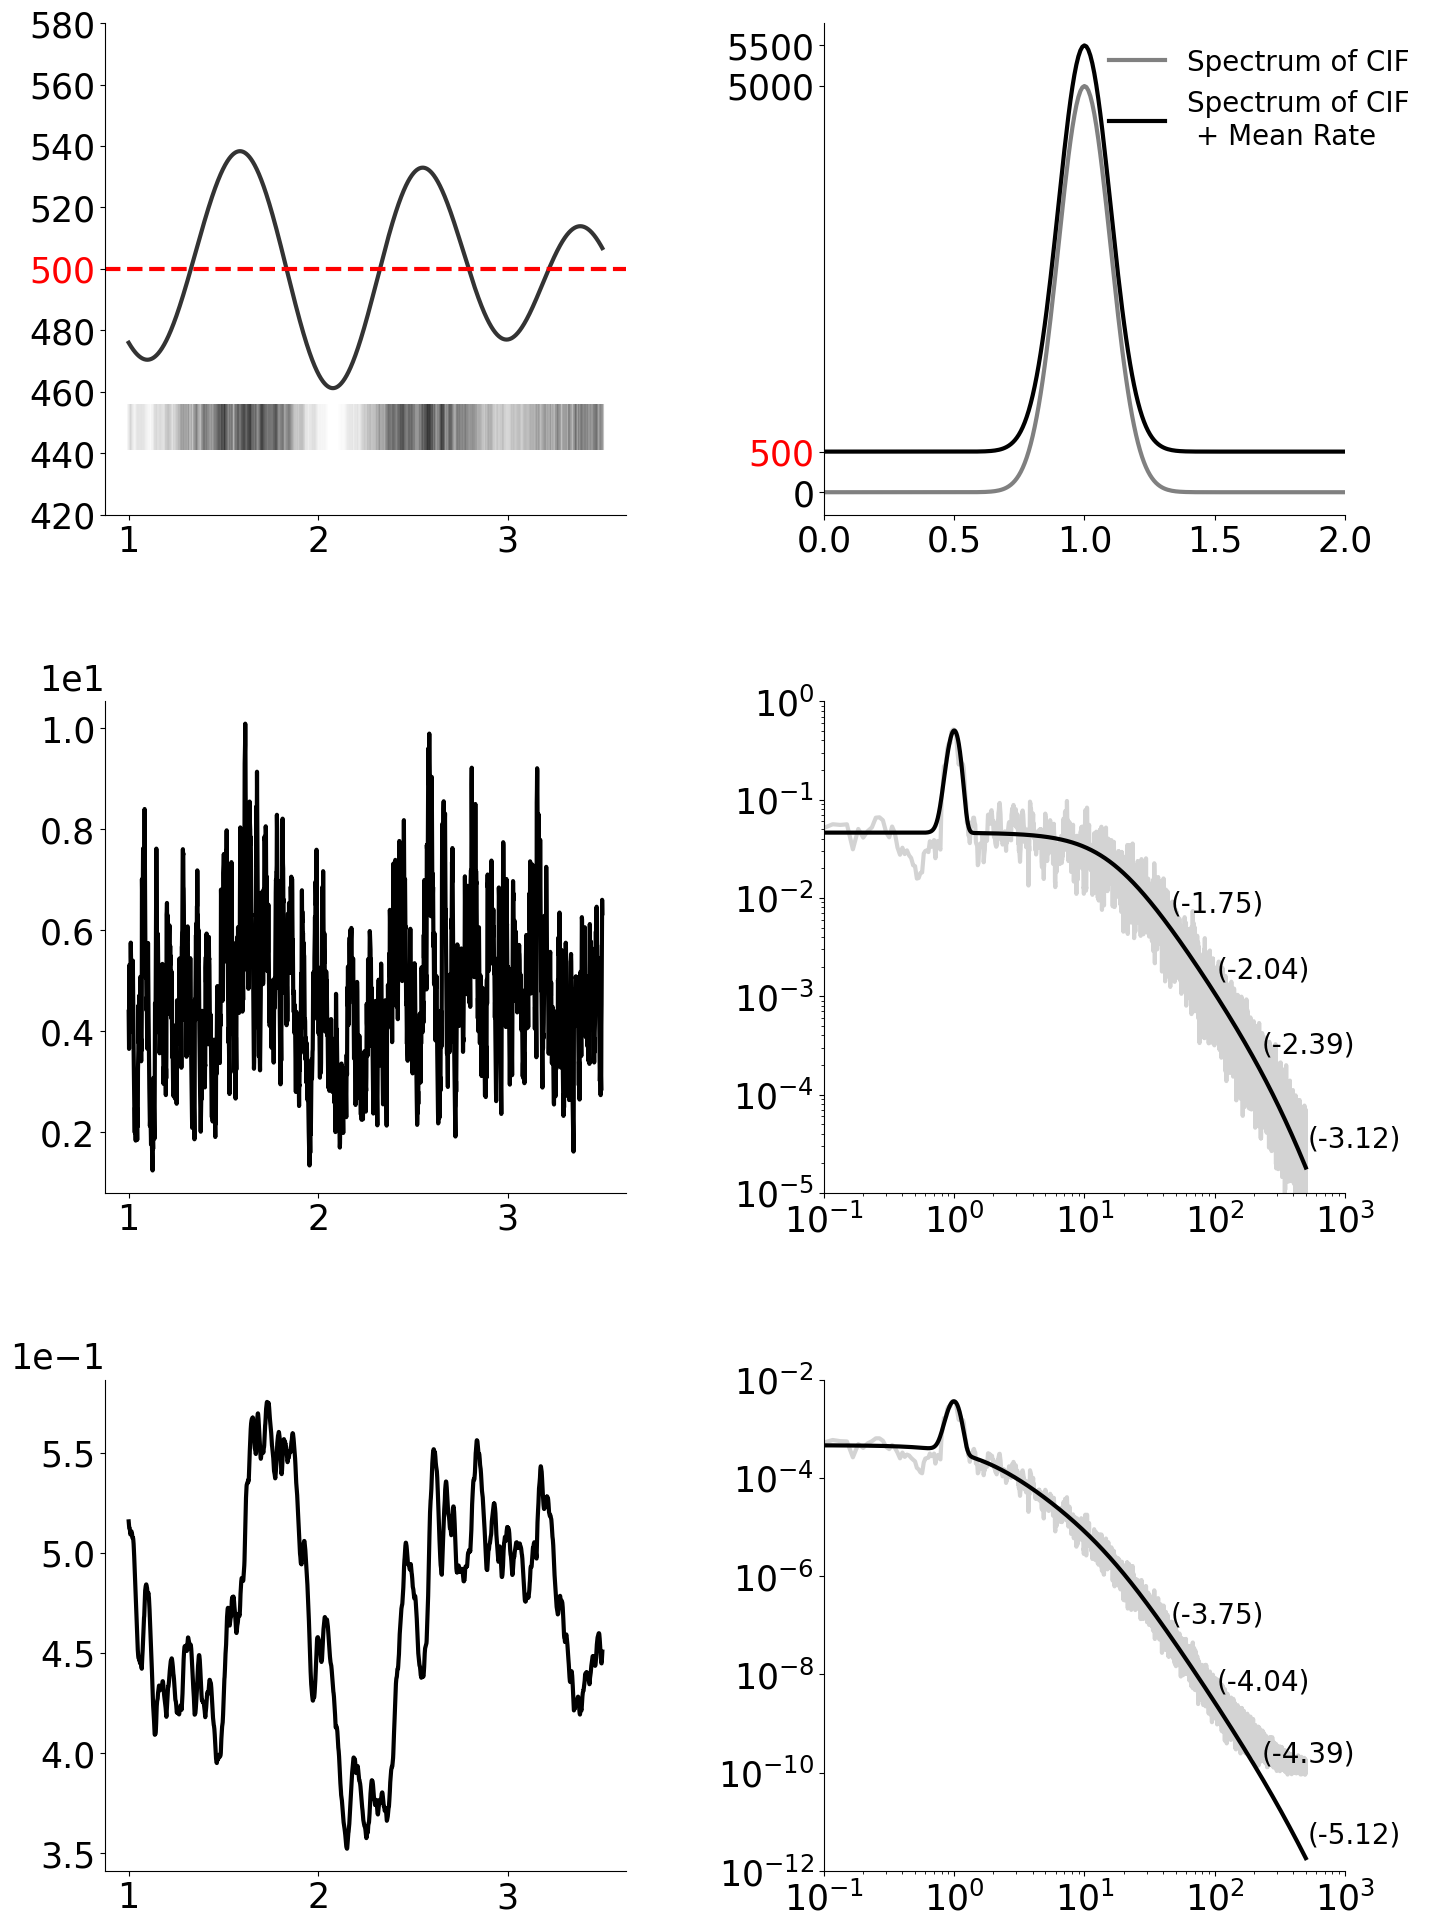

In [20]:
from spectral_connectivity import Multitaper, Connectivity


t = time_axis[1000:3500]
cif_subset = cif_copy[1000:3500]
spike_train_subset = spike_train[1000:3500]

sim_PSPs_GABA_sub = sim_PSPs_GABA[1000:3500]
sim_PSPs_GABA_1f_sub = sim_PSPs_GABA_1f[1000:3500]

cif_min, cif_max = np.min(cif_subset), np.max(cif_subset)

# For the PSD, we do a multi-taper on the final signals
mt_GABA = Multitaper(
    sim_PSPs_GABA,
    sampling_frequency=1000,
    time_halfbandwidth_product=4.0,
)
conn_combined = Connectivity.from_multitaper(mt_GABA)
psd_GABA = conn_combined.power().squeeze().T
freqs_GABA = conn_combined.frequencies


mt_combined = Multitaper(
    sim_PSPs_GABA_1f,
    sampling_frequency=1000,
    time_halfbandwidth_product=4.0,
)
conn_combined = Connectivity.from_multitaper(mt_combined)
psd_GABA_1f = conn_combined.power().squeeze().T
freqs_GABA_1f = conn_combined.frequencies

#freqs_GABA, psd_GABA, nu = tsa.multi_taper_psd(sim_PSPs_GABA, Fs=1000, NW=2, adaptive=False)
#freqs_GABA_1f, psd_GABA_1f, nu = tsa.multi_taper_psd(sim_PSPs_GABA_1f, Fs=1000, NW=2, adaptive=False)

plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)
plt.rc("axes", labelsize=14)
plt.rcParams["lines.linewidth"] = 3

def log_log_slope(f, spectrum, freq_vec):
    idx = np.argmin(np.abs(freq_vec - f))
    d_log_spectrum = nd.Derivative(
        lambda log_f: np.log10(spectrum[np.argmin(np.abs(freq_vec - 10**log_f))])
    )
    return d_log_spectrum(np.log10(freq_vec[idx]))

def annotate_slope(
    ax,
    spectrum,
    freq_vec,
    selected_frequencies=None,
    label_color="black",
    label_size=20,
    label_shift=(1.15, 1.15),
):
    if selected_frequencies is None:
        selected_frequencies = np.logspace(np.log10(40), np.log10(450), 4)
    for f in selected_frequencies:
        idx = np.argmin(np.abs(freq_vec - f))
        d_log_spectrum = nd.Derivative(
            lambda log_f: np.log10(
                spectrum[np.argmin(np.abs(freq_vec - 10**log_f))]
            )
        )
        slope_val = d_log_spectrum(np.log10(freq_vec[idx]))
        ax.text(
            freq_vec[idx]*label_shift[0],
            spectrum[idx]*label_shift[1],
            f"({slope_val:.2f})",
            fontsize=label_size,
            color=label_color
        )

# 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 24))

# (0,0): CIF + spikes
axs[0, 0].plot(t, cif_subset, color="black", alpha=0.8)

# alpha scaling for spikes
normalized_cif = (cif_subset - cif_min)/(cif_max - cif_min)
alpha_range_min, alpha_range_max = 0.001, 0.1
scaled_alpha = alpha_range_min + (alpha_range_max - alpha_range_min)*normalized_cif

spike_indices = np.nonzero(spike_train_subset)[0]
for idx in spike_indices:
    spike_time = t[idx]
    alpha_val = scaled_alpha[idx]
    axs[0, 0].vlines(spike_time, ymin=cif_min-20, ymax=cif_min-5, color="black", alpha=alpha_val)

# Red dashed line at 500
axs[0, 0].axhline(y=500, color="red", linestyle="--")
axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 0].set_ylim([cif_min-30, cif_max+30])

yticks = axs[0, 0].get_yticks()
if 500 not in yticks:
    yticks = np.append(yticks, 500)
axs[0, 0].set_yticks(yticks)
axs[0, 0].set_yticklabels([f"{int(y)}" for y in yticks])
for lab in axs[0, 0].get_yticklabels():
    if lab.get_text() == "500":
        lab.set_color("red")

# (0,1): Power spectra (CIF, CIF+Mean)
axs[0, 1].plot(frequencies, cif_PSD, label="Spectrum of CIF", color="grey")
axs[0, 1].plot(frequencies, pp_PSD, label="Spectrum of CIF \n + Mean Rate", color="black")
axs[0, 1].set_xlim(0, 2)
# Set custom y-axis ticks and make 500 red
axs[0, 1].set_yticks([0, 500, 5000, 5500])
axs[0, 1].get_yticklabels()[axs[0, 1].get_yticks().tolist().index(500)].set_color("red")

# Adding legends
legend_main = axs[0, 1].legend(
    loc="upper left", bbox_to_anchor=(0.5, 1), frameon=False, fontsize=20
)

axs[0, 1].legend(loc="upper left", bbox_to_anchor=(0.5, 1), frameon=False, fontsize=20)
axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)

# (1,0): GABA time series
axs[1, 0].plot(t, sim_PSPs_GABA_sub, color="black")
axs[1, 0].spines["top"].set_visible(False)
axs[1, 0].spines["right"].set_visible(False)

# (1,1): GABA log-log PSD
axs[1, 1].loglog(freqs_GABA, psd_GABA, color="lightgrey", label="GABA Multitaper PSD")
axs[1, 1].loglog(frequencies, h_spectrum, label="GABA Filter Power Spectrum", color="black")
axs[1, 1].set_xlim([0.1, 1000])
axs[1, 1].set_ylim([1e-5, 1e0])
axs[1, 1].spines["top"].set_visible(False)
axs[1, 1].spines["right"].set_visible(False)
#axs[1, 1].set_frame_on(False)
annotate_slope(axs[1, 1], h_spectrum, frequencies)

# (2,0): GABA + 1/f time series
axs[2, 0].plot(t, sim_PSPs_GABA_1f_sub, color="black")
axs[2, 0].spines["top"].set_visible(False)
axs[2, 0].spines["right"].set_visible(False)

# (2,1): GABA + 1/f log-log PSD
axs[2, 1].loglog(freqs_GABA_1f, psd_GABA_1f, color="lightgrey", label="GABA 1/f Multitaper PSD")
axs[2, 1].loglog(frequencies, final_spectrum, label="1/f-like filtered Power Spectrum", color="black")
axs[2, 1].set_xlim([0.1, 1000])
axs[2, 1].set_ylim([1e-12, 1e-2])
axs[2, 1].spines["top"].set_visible(False)
axs[2, 1].spines["right"].set_visible(False)
annotate_slope(axs[2, 1], final_spectrum, frequencies)

# Cosmetic touches
for i in range(3):
    for j in range(2):
        if i == 0 and j < 2:
            continue  # don't override the top row formatting
        ax = axs[i, j]
        if not isinstance(ax.yaxis.get_major_formatter(), mticker.LogFormatterSciNotation):
            ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
            ax.yaxis.offsetText.set_position((0, 1))
            ax.yaxis.offsetText.set_verticalalignment("bottom")
            ax.yaxis.offsetText.set_horizontalalignment("right")

fig.subplots_adjust(hspace=0.38, wspace=0.38)
plt.show()

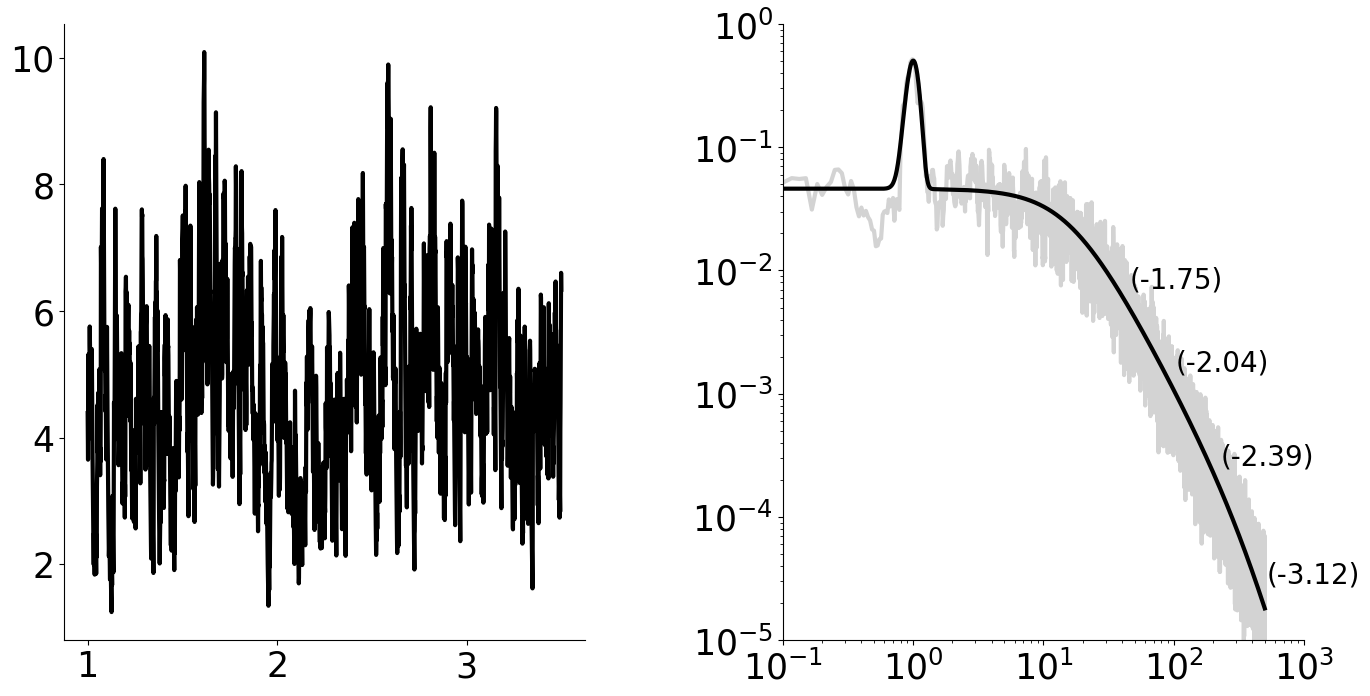

In [22]:
# ─── Middle-panels only figure ───
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)
plt.rc("axes", labelsize=14)
plt.rcParams["lines.linewidth"] = 3

# create a new 1×2 figure (height scaled to one row of the original)
fig_mid, axs_mid = plt.subplots(1, 2, figsize=(16, 8))

# (1,0) → left: GABA time series
axs_mid[0].plot(t, sim_PSPs_GABA_sub, color="black")
axs_mid[0].spines["top"].set_visible(False)
axs_mid[0].spines["right"].set_visible(False)

# (1,1) → right: GABA log-log PSD
axs_mid[1].loglog(freqs_GABA, psd_GABA, color="lightgrey", label="GABA Multitaper PSD")
axs_mid[1].loglog(frequencies, h_spectrum, color="black", label="GABA Filter Power Spectrum")
axs_mid[1].set_xlim([0.1, 1000])
axs_mid[1].set_ylim([1e-5, 1e0])
axs_mid[1].spines["top"].set_visible(False)
axs_mid[1].spines["right"].set_visible(False)
annotate_slope(axs_mid[1], h_spectrum, frequencies)

# tighten spacing to match original wspace
fig_mid.subplots_adjust(wspace=0.38)

# save under a distinct name
outdir = '...'
plt.savefig(f'{outdir}/Figure_2_middle_panels.svg')
plt.savefig(f'{outdir}/Figure_2_middle_panels.png', dpi=300)
plt.show()
